In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2024-05-08 14:11:50--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  17.6MB/s    in 0.4s    

2024-05-08 14:11:51 (17.6 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [ ]:
!unzip -o fra-eng.zip fra.txt
!mv fra.txt eng-fra.txt

Archive:  fra-eng.zip
  inflating: fra.txt                 


# Task 1

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from  sklearn.model_selection import validation_curve

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)

    return s.strip()

In [ ]:
!head *.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)
Run!	Cours !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906331 (sacredceltic)
Run!	Courez !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906332 (sacredceltic)
Run!	Prenez vos jambes à vos cous !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077449 (sacredceltic)
Run!	File !	CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #2077454 (sacredceltic)


In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:-1]] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
['il va mieux', 'he is getting better']


# Task 2

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

# Task 3

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# Task 4

In [ ]:
#@title Old code
# class LuongEncoderRNN(nn.Module):
#     def __init__(self, input_size, embedding, n_layers=1, dropout=0):
#         super().__init__()
#         self.n_layers = n_layers
#         self.hidden_size = hidden_size

#         # self.embedding = embedding
#         self.embedding = nn.Embedding(input_size, hidden_size)

#         # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
#         #   because our input size is a word embedding with number of features == hidden_size
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
#                           dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

#     def forward(self, input_seq, input_lengths, hidden=None):
#         # print(list(zip(input_seq, input_lengths)))
#         # input_seq, input_lengths = zip((i1, i2) for i1, i2 in zip(input_seq, input_lengths) if i2 > 0)
#         # Convert word indexes to embeddings
#         embedded = self.embedding(input_seq)
#         # Pack padded batch of sequences for RNN module
#         packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
#         # Forward pass through GRU
#         outputs, hidden = self.gru(packed, hidden)
#         # Unpack padding
#         outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
#         # Sum bidirectional GRU outputs
#         outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
#         # Return output and final hidden state
#         return outputs, hidden

# # Luong attention layer
# class LuongAttention(nn.Module):
#     def __init__(self, method, hidden_size):
#         super().__init__()
#         self.method = method
#         if self.method not in ['dot', 'general', 'concat']:
#             raise ValueError(self.method, "is not an appropriate attention method.")
#         self.hidden_size = hidden_size
#         if self.method == 'general':
#             self.attn = nn.Linear(self.hidden_size, hidden_size)
#         elif self.method == 'concat':
#             self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
#             self.v = nn.Parameter(torch.FloatTensor(hidden_size))

#     def dot_score(self, hidden, encoder_output):
#         return torch.sum(hidden * encoder_output, dim=2)

#     def general_score(self, hidden, encoder_output):
#         energy = self.attn(encoder_output)
#         return torch.sum(hidden * energy, dim=2)

#     def concat_score(self, hidden, encoder_output):
#         energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
#         return torch.sum(self.v * energy, dim=2)

#     def forward(self, hidden, encoder_outputs):
#         # Calculate the attention weights (energies) based on the given method
#         if self.method == 'general':
#             attn_energies = self.general_score(hidden, encoder_outputs)
#         elif self.method == 'concat':
#             attn_energies = self.concat_score(hidden, encoder_outputs)
#         elif self.method == 'dot':
#             attn_energies = self.dot_score(hidden, encoder_outputs)

#         # Transpose max_length and batch_size dimensions
#         attn_energies = attn_energies.t()

#         # Return the softmax normalized probability scores (with added dimension)
#         return F.softmax(attn_energies, dim=1).unsqueeze(1)

# class LuongAttnDecoderRNN(nn.Module):
#     def __init__(self, hidden_size, output_size, n_layers=1, dropout=0.1):
#         super().__init__()

#         # Keep for reference
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.n_layers = n_layers
#         self.dropout = dropout

#         # Define layers
#         # self.embedding = embedding
#         self.embedding = nn.Embedding(output_size, hidden_size)
#         self.embedding_dropout = nn.Dropout(dropout)
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
#         self.concat = nn.Linear(hidden_size * 2, hidden_size)
#         self.out = nn.Linear(hidden_size, output_size)

#         self.attn = LuongAttention("dot", hidden_size)

#     def forward(self, input_step, last_hidden, encoder_outputs):
#         # Note: we run this one step (word) at a time
#         # Get embedding of current input word
#         print(input_step.long())
#         embedded = self.embedding(input_step.long())
#         embedded = self.embedding_dropout(embedded)
#         # Forward through unidirectional GRU
#         rnn_output, hidden = self.gru(embedded, last_hidden)
#         # Calculate attention weights from the current GRU output
#         attn_weights = self.attn(rnn_output, encoder_outputs)
#         # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
#         context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
#         # Concatenate weighted context vector and GRU output using Luong eq. 5
#         rnn_output = rnn_output.squeeze(0)
#         context = context.squeeze(1)
#         concat_input = torch.cat((rnn_output, context), 1)
#         concat_output = torch.tanh(self.concat(concat_input))
#         # Predict next word using Luong eq. 6
#         output = self.out(concat_output)
#         output = F.softmax(output, dim=1)
#         # Return output and final hidden state
#         return output, hidden

In [ ]:
#@title Old code
# class LuongEncoderRNN(nn.Module):
#     def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
#         super().__init__()
#         self.n_layers = n_layers
#         self.hidden_size = hidden_size
#         self.embedding = embedding

#         # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
#         #   because our input size is a word embedding with number of features == hidden_size
#         self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
#                           dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

#     def forward(self, input_seq, input_lengths, hidden=None):
#         # Convert word indexes to embeddings
#         embedded = self.embedding(input_seq)
#         # Pack padded batch of sequences for RNN module
#         packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
#         # Forward pass through GRU
#         outputs, hidden = self.gru(packed, hidden)
#         # Unpack padding
#         outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
#         # Sum bidirectional GRU outputs
#         outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
#         # Return output and final hidden state
#         return outputs, hidden

In [ ]:
from torch.nn.functional import softmax

# Adapted from https://blog.paperspace.com/introduction-to-neural-machine-translation-with-bahdanaus-attention/

class LuongAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

    def forward(self, decoder_hidden, encoder_outputs):
        scores = encoder_outputs.bmm(decoder_hidden.view(1,-1,1)).squeeze(-1)

        weights = softmax(scores.view(1, -1), dim=1)

        context_vector = torch.bmm(weights.unsqueeze(0), encoder_outputs)

        return context_vector, weights

class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super().__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

# Tasks 5 and 6
The training is part of Task 5 and the visualization is part of Task 6.

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [ ]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
@torch.no_grad()
def validate_epoch(dataloader, encoder, decoder, criterion):
    encoder.eval()
    decoder.eval()

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()

    training_losses = []
    training_print_loss_total = 0  # Reset every print_every
    training_plot_loss_total = 0  # Reset every plot_every

    validation_losses = []
    validation_print_loss_total = 0  # Reset every print_every
    validation_plot_loss_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        training_print_loss_total += loss
        training_plot_loss_total += loss

        loss = validate_epoch(train_dataloader, encoder, decoder, criterion)
        validation_print_loss_total += loss
        validation_plot_loss_total += loss

        if epoch % print_every == 0:
            training_print_loss_avg = training_print_loss_total / print_every
            training_print_loss_total = 0

            validation_print_loss_avg = validation_print_loss_total / print_every
            validation_print_loss_total = 0

            print('%s (%d %d%%)\tTraining: %.4f\tValidation: %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, training_print_loss_avg, validation_print_loss_avg))

        if epoch % plot_every == 0:
            training_loss_avg = training_plot_loss_total / plot_every
            training_losses.append(training_loss_avg)
            training_plot_loss_total = 0

            validation_loss_avg = validation_plot_loss_total / plot_every
            validation_losses.append(training_loss_avg)
            validation_plot_loss_total = 0

    plotPoints(training_losses, validation_losses)

In [ ]:
import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def plotPoints(training_points, validation_points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(training_points, marker='o', color='blue', label='Training Loss', linewidth=3)
    plt.plot(validation_points, marker='o', color='orange', label='Evaluation Loss')

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
hidden_size = 128
batch_size = 32

## 1. Training Seq2seq without Attention

### 20 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
5m 4s (- 15m 14s) (5 25%)	Training: 1.5816	Validation: 1.3386
10m 20s (- 10m 20s) (10 50%)	Training: 0.7939	Validation: 0.6997
15m 27s (- 5m 9s) (15 75%)	Training: 0.4765	Validation: 0.4122
20m 33s (- 0m 0s) (20 100%)	Training: 0.3013	Validation: 0.2566


<Figure size 640x480 with 0 Axes>

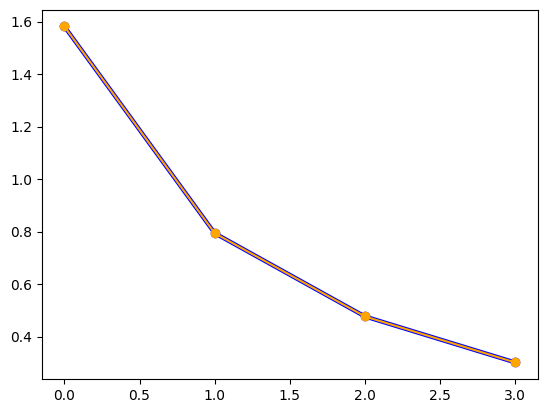

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

no_attention_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
no_attention_decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, no_attention_encoder, no_attention_decoder, 20, print_every=5, plot_every=5)

In [ ]:
no_attention_encoder.eval()
no_attention_decoder.eval()
evaluateRandomly(no_attention_encoder, no_attention_decoder)

> elle est dotee d un talent special
= she is endowed with a special talent
< she is endowed with a nervous because of still here

> il se rapproche
= he s coming closer
< he is always complaining about his grandfather <EOS>

> il porte ses livres sous son bras
= he is holding his books under his arm
< he is doing what his grandfather <EOS>

> vous etes maigrichon
= you re skinny
< you re ready to go <EOS>

> je ne suis pas en mal d argent
= i m not pressed for money
< i m not in any pain at the moment <EOS>

> je suis celui qui va mourir
= i m the one who s going to die
< i m the one who told tom s late <EOS>

> tu n es pas autorise a stationner la
= you re not allowed to park there
< you aren t allowed to park there <EOS>

> je suis trop jeune pour faire ca
= i m too young to do that
< i m too young to do that by myself <EOS>

> elles sont en retard comme d habitude
= they re late as usual
< they are late late <EOS>

> je suis chanteuse
= i m a singer
< i m a little bit for a drink <

### 50 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
5m 2s (- 45m 19s) (5 10%)	Training: 1.5879	Validation: 1.3412
10m 2s (- 40m 8s) (10 20%)	Training: 0.7781	Validation: 0.6792
15m 2s (- 35m 5s) (15 30%)	Training: 0.4461	Validation: 0.3814
20m 6s (- 30m 10s) (20 40%)	Training: 0.2666	Validation: 0.2232
25m 5s (- 25m 5s) (25 50%)	Training: 0.1694	Validation: 0.1405
30m 7s (- 20m 5s) (30 60%)	Training: 0.1174	Validation: 0.0980
35m 16s (- 15m 6s) (35 70%)	Training: 0.0875	Validation: 0.0724
40m 27s (- 10m 6s) (40 80%)	Training: 0.0722	Validation: 0.0609
45m 47s (- 5m 5s) (45 90%)	Training: 0.0616	Validation: 0.0512
50m 56s (- 0m 0s) (50 100%)	Training: 0.0566	Validation: 0.0465


<Figure size 640x480 with 0 Axes>

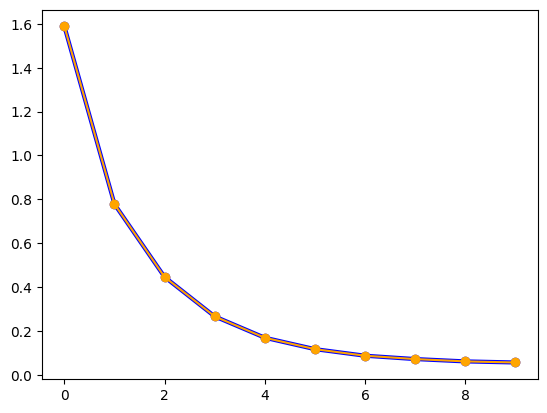

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

no_attention_encoder50 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
no_attention_decoder50 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, no_attention_encoder50, no_attention_decoder50, 50, print_every=5, plot_every=5)

In [ ]:
no_attention_encoder50.eval()
no_attention_decoder50.eval()
evaluateRandomly(no_attention_encoder50, no_attention_decoder50)

> je suis certaine d avoir ferme le gaz
= i m sure i turned off the gas
< i m sure i turned off the gas <EOS>

> c est une boule de nerfs
= he s a nervous wreck
< he s a stand up as his mother <EOS>

> je suis mariee et j ai deux fils
= i am married and i have two sons
< i am married and i have two sons <EOS>

> je fais des ufs brouilles
= i m making scrambled eggs
< i m making scrambled eggs <EOS>

> je suis parfait pour vous
= i m perfect for you
< i m perfect for you <EOS>

> c est l amour de ma vie
= he s the love of my life
< he s the love of my life left <EOS>

> je perds mes cheveux
= i m going bald
< i m going to go wash my hair <EOS>

> tu t es gare sur ma place
= you re parked in my space
< you re parked in my space <EOS>

> je suis tres sensible au froid
= i m very sensitive to the cold
< i m very interested in japanese history <EOS>

> je n ai pas si soif que ca
= i m not really that thirsty
< i m not really that thirsty <EOS>



## 2. Training Seq2seq with Additive Attention (Bahdanau)

### 20 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
6m 42s (- 20m 8s) (5 25%)	Training: 1.3446	Validation: 1.0635
13m 25s (- 13m 25s) (10 50%)	Training: 0.4309	Validation: 0.3407
20m 0s (- 6m 40s) (15 75%)	Training: 0.1714	Validation: 0.1350
26m 34s (- 0m 0s) (20 100%)	Training: 0.0921	Validation: 0.0743


<Figure size 640x480 with 0 Axes>

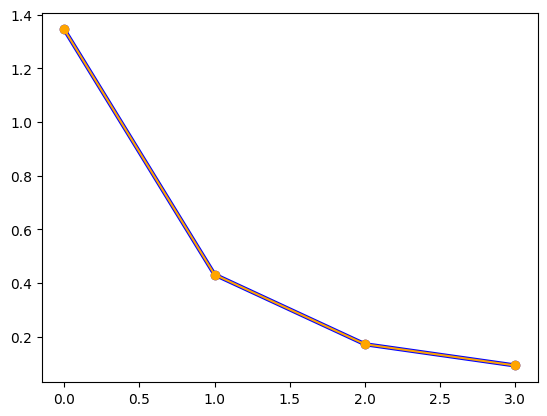

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

bahdanau_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
bahdanau_decoder = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, bahdanau_encoder, bahdanau_decoder, 20, print_every=5, plot_every=5)

In [ ]:
bahdanau_encoder.eval()
bahdanau_decoder.eval()
evaluateRandomly(bahdanau_encoder, bahdanau_decoder)

> je suis methodique
= i m methodical
< i m methodical <EOS>

> je crains qu il commette une erreur
= i am afraid he will make a mistake
< i am afraid he will make a mistake <EOS>

> il n y va pas
= he s not going
< you re not going <EOS>

> elle a loupe le coche
= she s missed the boat
< she s missed the boat <EOS>

> je suis heureuse que les gens l aient vu
= i m glad people saw it
< i m glad people saw it <EOS>

> je ne fais que supposer
= i m just guessing
< i m just guessing surprised <EOS>

> je n en suis pas convaincue
= i m not convinced of that
< i m not convinced of that <EOS>

> je vais reflechir a ca
= i m going to figure this out
< i m going to figure this out <EOS>

> elles ne sont pas onereuses
= they re not expensive
< they re not expensive that <EOS>

> il a trois ans de plus qu elle
= he s three years older than she is
< he s three years older than her <EOS>



### 50 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
6m 23s (- 57m 27s) (5 10%)	Training: 1.3769	Validation: 1.1029
12m 43s (- 50m 54s) (10 20%)	Training: 0.4585	Validation: 0.3636
19m 12s (- 44m 49s) (15 30%)	Training: 0.1808	Validation: 0.1411
25m 40s (- 38m 31s) (20 40%)	Training: 0.0951	Validation: 0.0777
32m 9s (- 32m 9s) (25 50%)	Training: 0.0675	Validation: 0.0557
38m 42s (- 25m 48s) (30 60%)	Training: 0.0557	Validation: 0.0446
45m 15s (- 19m 23s) (35 70%)	Training: 0.0501	Validation: 0.0410
51m 37s (- 12m 54s) (40 80%)	Training: 0.0463	Validation: 0.0371
57m 59s (- 6m 26s) (45 90%)	Training: 0.0430	Validation: 0.0352
64m 21s (- 0m 0s) (50 100%)	Training: 0.0422	Validation: 0.0338


<Figure size 640x480 with 0 Axes>

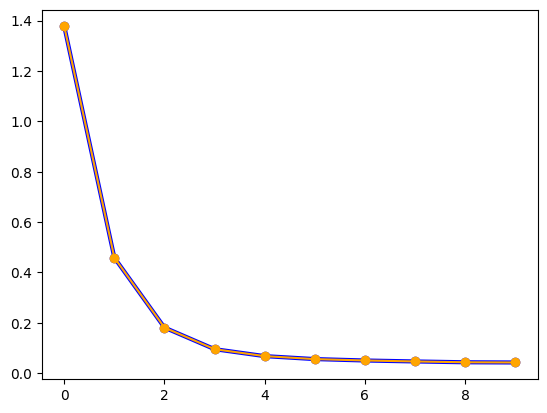

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

bahdanau_encoder50 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
bahdanau_decoder50 = BahdanauAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, bahdanau_encoder50, bahdanau_decoder50, 50, print_every=5, plot_every=5)

In [ ]:
bahdanau_encoder50.eval()
bahdanau_decoder50.eval()
evaluateRandomly(bahdanau_encoder50, bahdanau_decoder50)

> il est doue pour prendre des photos
= he is good at taking photos
< he is good at taking photos <EOS>

> je suis japonais
= i am a japanese
< to is a japanese <EOS>

> je cherche un portefeuille
= i m looking for a wallet
< i am looking for a wallet <EOS>

> je suis completement deborde
= i m absolutely swamped
< i m absolutely swamped <EOS>

> je suis trop gros
= i m too fat
< i m too fat <EOS>

> jamais il n a ete amoureux auparavant
= he s never been in love before
< he s never been in love before <EOS>

> elle est dure avec eux
= she is hard on them
< she is hard on them <EOS>

> elle est vraiment une fille ravissante
= she s a real hottie
< she s really a nice girl <EOS>

> vous etes en premier
= you re first
< you re first <EOS>

> je ne vais pas bien
= i m not well
< i m not well <EOS>



## 3. Seq2seq with Dot-Product Attention (Luong)

### 20 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
6m 35s (- 19m 45s) (5 25%)	Training: 1.3303	Validation: 1.0544
13m 15s (- 13m 15s) (10 50%)	Training: 0.4151	Validation: 0.3256
19m 54s (- 6m 38s) (15 75%)	Training: 0.1628	Validation: 0.1279
26m 22s (- 0m 0s) (20 100%)	Training: 0.0906	Validation: 0.0730


<Figure size 640x480 with 0 Axes>

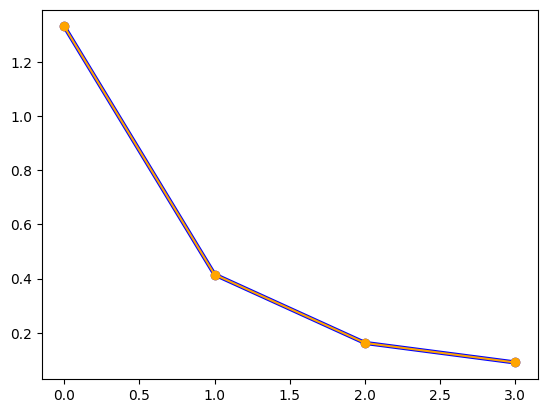

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

luong_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
luong_decoder = LuongAttnDecoderRNN(hidden_size, output_lang.n_words, 0.1).to(device)

train(train_dataloader, luong_encoder, luong_decoder, 20, print_every=5, plot_every=5)

In [ ]:
luong_encoder.eval()
luong_decoder.eval()
evaluateRandomly(luong_encoder, luong_decoder)

> je suis un lyceen
= i m a high school student
< i m a high school student <EOS>

> elles sont nerveuses
= they re jittery
< they re nervous <EOS>

> je ne suis pas ta s ur
= i m not your sister
< i m not your sister <EOS>

> chat !
= you re it !
< you re it ! <EOS>

> je suis fichu
= i m doomed
< i m doomed <EOS>

> tu n es pas autorisee a manger ceux la
= you re not allowed to eat those
< you re not allowed to eat those <EOS>

> ce sont des jeunes filles serieuses
= they are sensible girls
< they are sensible girls <EOS>

> nous sommes observes
= we re being watched
< we re being watched <EOS>

> tu as juste un peu le mal du pays
= you re just a little homesick
< you re just a little homesick <EOS>

> je ne suis qu un chauffeur de taxi
= i m just a taxi driver
< i m just a taxi driver <EOS>



### 50 Epochs

Reading lines...
Read 232736 sentence pairs
Trimmed to 18199 sentence pairs
Counting words...
Counted words:
fra 5751
eng 3748
6m 47s (- 20m 21s) (5 25%)	Training: 1.3190	Validation: 1.0425
13m 12s (- 13m 12s) (10 50%)	Training: 0.4106	Validation: 0.3222
19m 17s (- 6m 25s) (15 75%)	Training: 0.1598	Validation: 0.1253
25m 37s (- 0m 0s) (20 100%)	Training: 0.0888	Validation: 0.0713


<Figure size 640x480 with 0 Axes>

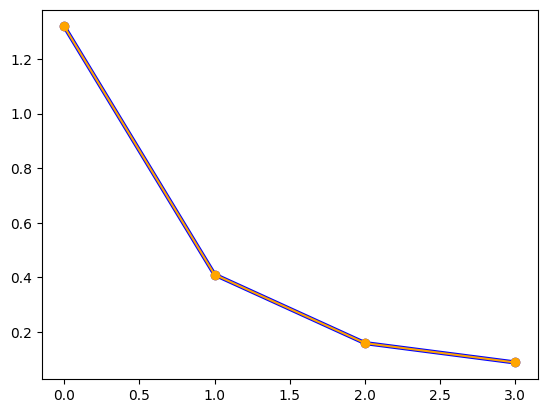

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

luong_encoder50 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
luong_decoder50 = LuongAttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, luong_encoder50, luong_decoder50, 20, print_every=5, plot_every=5)

In [ ]:
luong_encoder50.eval()
luong_decoder50.eval()
evaluateRandomly(luong_encoder50, luong_decoder50)

> tu vas devoir arreter de faire ca
= you re going to have to stop doing that
< you re going to have to stop doing that <EOS>

> elle vient de france
= she is from france
< she is from france by nature <EOS>

> ce ne sont que des enfants riches
= they re just rich kids
< they re just rich kids japanese <EOS>

> ils vont tous nous tuer !
= they re going to kill us all
< they re going to kill us all us <EOS>

> nous sommes aventureuses
= we re adventurous
< we re stupid <EOS>

> je suis ecrivain
= i m a writer
< i m a writer <EOS>

> tu es trop decontracte
= you re too laid back
< you re too laid back <EOS>

> nous nous deshabillons
= we re undressing
< we re undressing <EOS>

> je suis desole si ma presence vous embarrasse
= i m sorry if my being here embarrasses you
< i m sorry if my being here embarrasses you <EOS>

> je suis engagee
= i m committed
< i m committed <EOS>



# Task 7

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    encoder.eval()
    decoder.eval()

    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

## Bahdanau

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-45-9df839ed8816>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-45-9df839ed8816>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


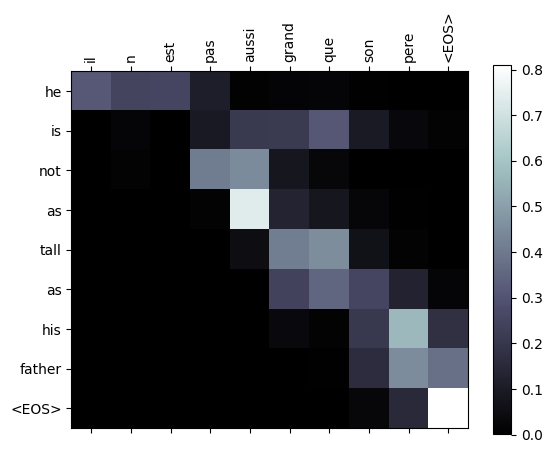

input = je suis trop fatigue pour conduire
output = i m too tired to drive to drive <EOS>


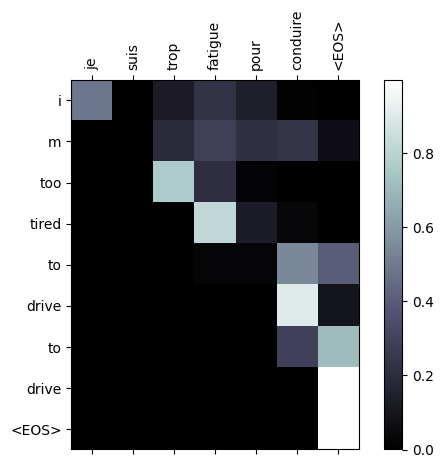

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


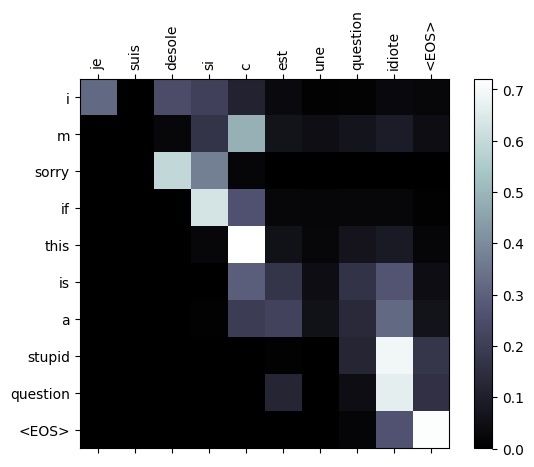

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


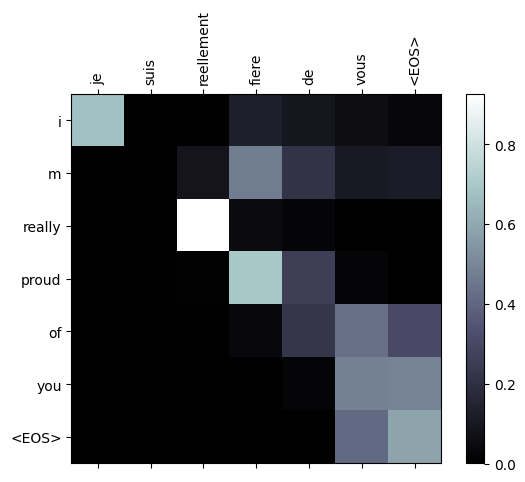

In [ ]:
encoder = bahdanau_encoder
decoder = bahdanau_decoder

evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

## Luong

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


<ipython-input-45-9df839ed8816>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-45-9df839ed8816>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


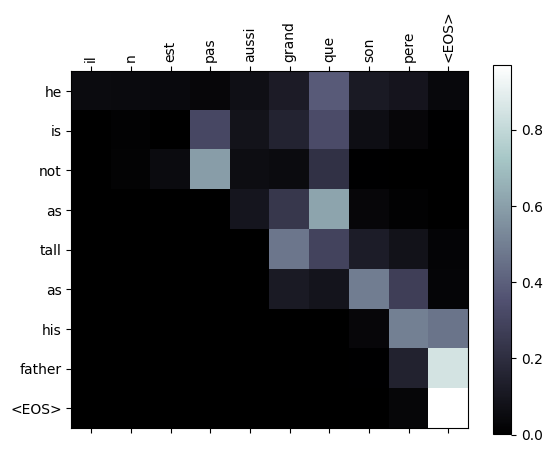

input = je suis trop fatigue pour conduire
output = i m too tired to drive <EOS>


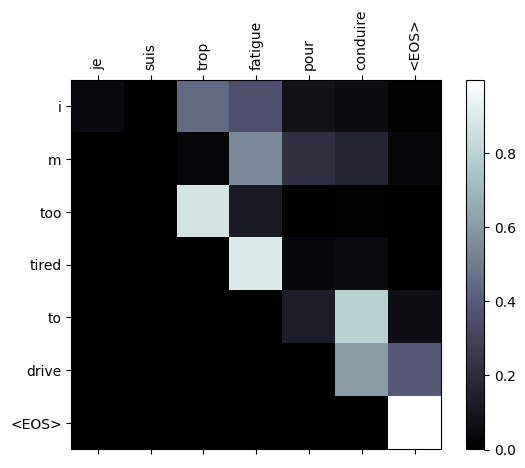

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


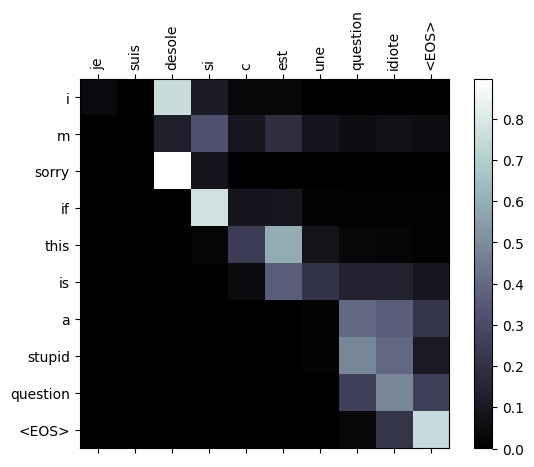

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


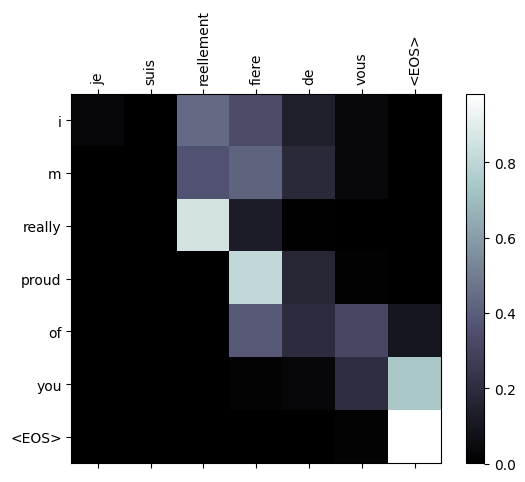

In [ ]:
encoder = luong_encoder
decoder = luong_decoder

evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')